## Table of Contents

1. [Importing Packages](#1-importing-packages)
2. [Target Variable Analysis](#2-target-variable-analysis)
3. [Univariate Analysis for Features](#3-univariate-analysis-for-features)
4. [Bivariate Analysis of Features and Targets](#4-bivariate-analysis-of-features-and-target)
5. [Bivariate Analysis amongst Features](#5-bivariate-analysis-amongst-features)

## 1. Importing Packages

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import chi2_contingency
from itertools import combinations

sys.path.append('..')

## 2. Target Variable Analysis

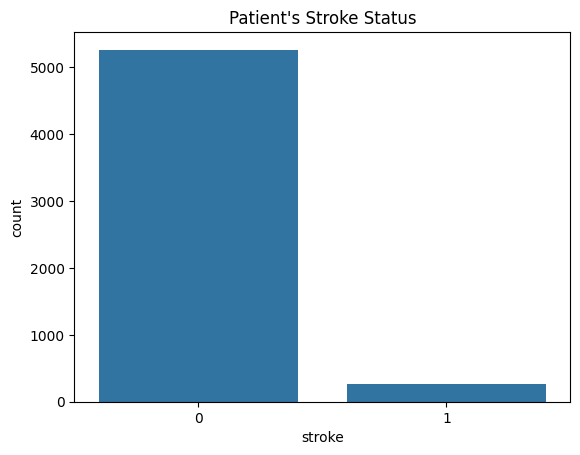

        Number of Values  Proportion of Values
stroke                                        
0                   5259             95.151077
1                    268              4.848923


In [10]:
df_cleaned = pd.read_csv("../data/stroke_dataset_cleaned.csv")

stroke_values = pd.DataFrame({
    "Number of Values": df_cleaned["stroke"].value_counts(),
    "Proportion of Values": df_cleaned["stroke"].value_counts(normalize= True) * 100
})

sns.countplot(data = df_cleaned, x = "stroke")
plt.title("Patient's Stroke Status")
plt.show()

print(stroke_values)

Analysis of the distribution of values in the `stroke` column shows that there is a significant class imbalance (95% no stroke vs 5% with stroke). Therefore, there is a need to use a stratified split to ensure an equal distribution of both classes amongst the training and test set during the modelling process. Additionally, accuracy would not be a good metric to evaluate the model with such a significant amount of class imbalance, and other metrics (F1, Precision/Recall or ROC-AUC).

## 3. Univariate Analysis for Features

### Numerical Features

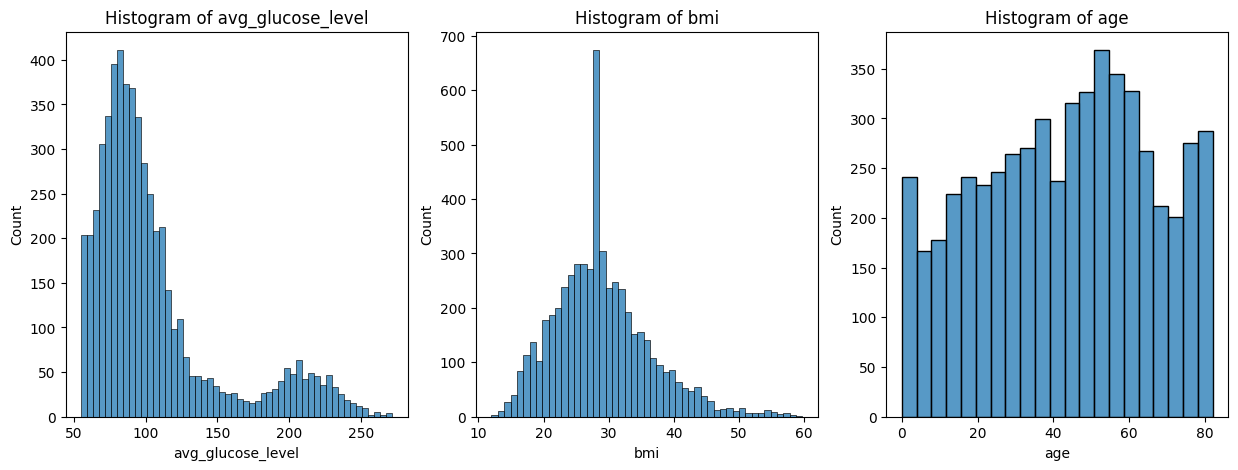

In [11]:
numerical_cols = ["avg_glucose_level", "bmi", "age"]

fig, axes = plt.subplots(1,3,figsize = (15,5))

for i, col in enumerate(numerical_cols):
    sns.histplot(data = df_cleaned, x= col, ax = axes[i])
    axes[i].set_title(f"Histogram of {col}")

plt.show()

**Distribution Analysis:**

`avg_glucose_level`: The distribution is right-skewed, with a majority of the values concentration between 70-150. There appears to be a secondary concentration around 200-250, which indicates a subgroup with diabetes. It would be worth considering to apply a log-transformation or robust scaling to handle the skewed data during model training.

`bmi`: The distribution appears approximately normal, centered around 28-30. There is a large spike in frequency at 29, which corresponds to the imputed median values used to fill missing values. 

`age`: The distribution shows a broad spread across various age groups, with peaks at around 0-4 and 45-65 years old. The dataset also appears more skewed towards older adults.

In [12]:
num_outliers = {}

for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    iqr = Q3 - Q1

    lower_bound = Q1 - 1.5 * iqr
    upper_bound = Q3 + 1.5 * iqr

    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    num_outliers[col] = {"num_outliers": len(outliers), "proportion_outliers": str(round(len(outliers) / len(df_cleaned) * 100, 2)) + "%"}

print(num_outliers)

{'avg_glucose_level': {'num_outliers': 677, 'proportion_outliers': '12.25%'}, 'bmi': {'num_outliers': 135, 'proportion_outliers': '2.44%'}, 'age': {'num_outliers': 0, 'proportion_outliers': '0.0%'}}


**Outlier Analysis:**

The boxplot of numeric values found a large number of outliers in both `avg_glucose_level` and `bmi` columns. In particular, there are 677 and 135 outliers in the `avg_glucose_level` and `bmi` columns respectively. However, these outliers are kept in the dataset in order to analyse how diabetes and obesity would influence the likelihood of a patient having stroke. No outliers were found in the `Age` column.

During the scaling process, it would be more ideal to use a RobustScaler as opposed to a StandardScaler as it would be less sensitive to outliers.

### Categorical Features

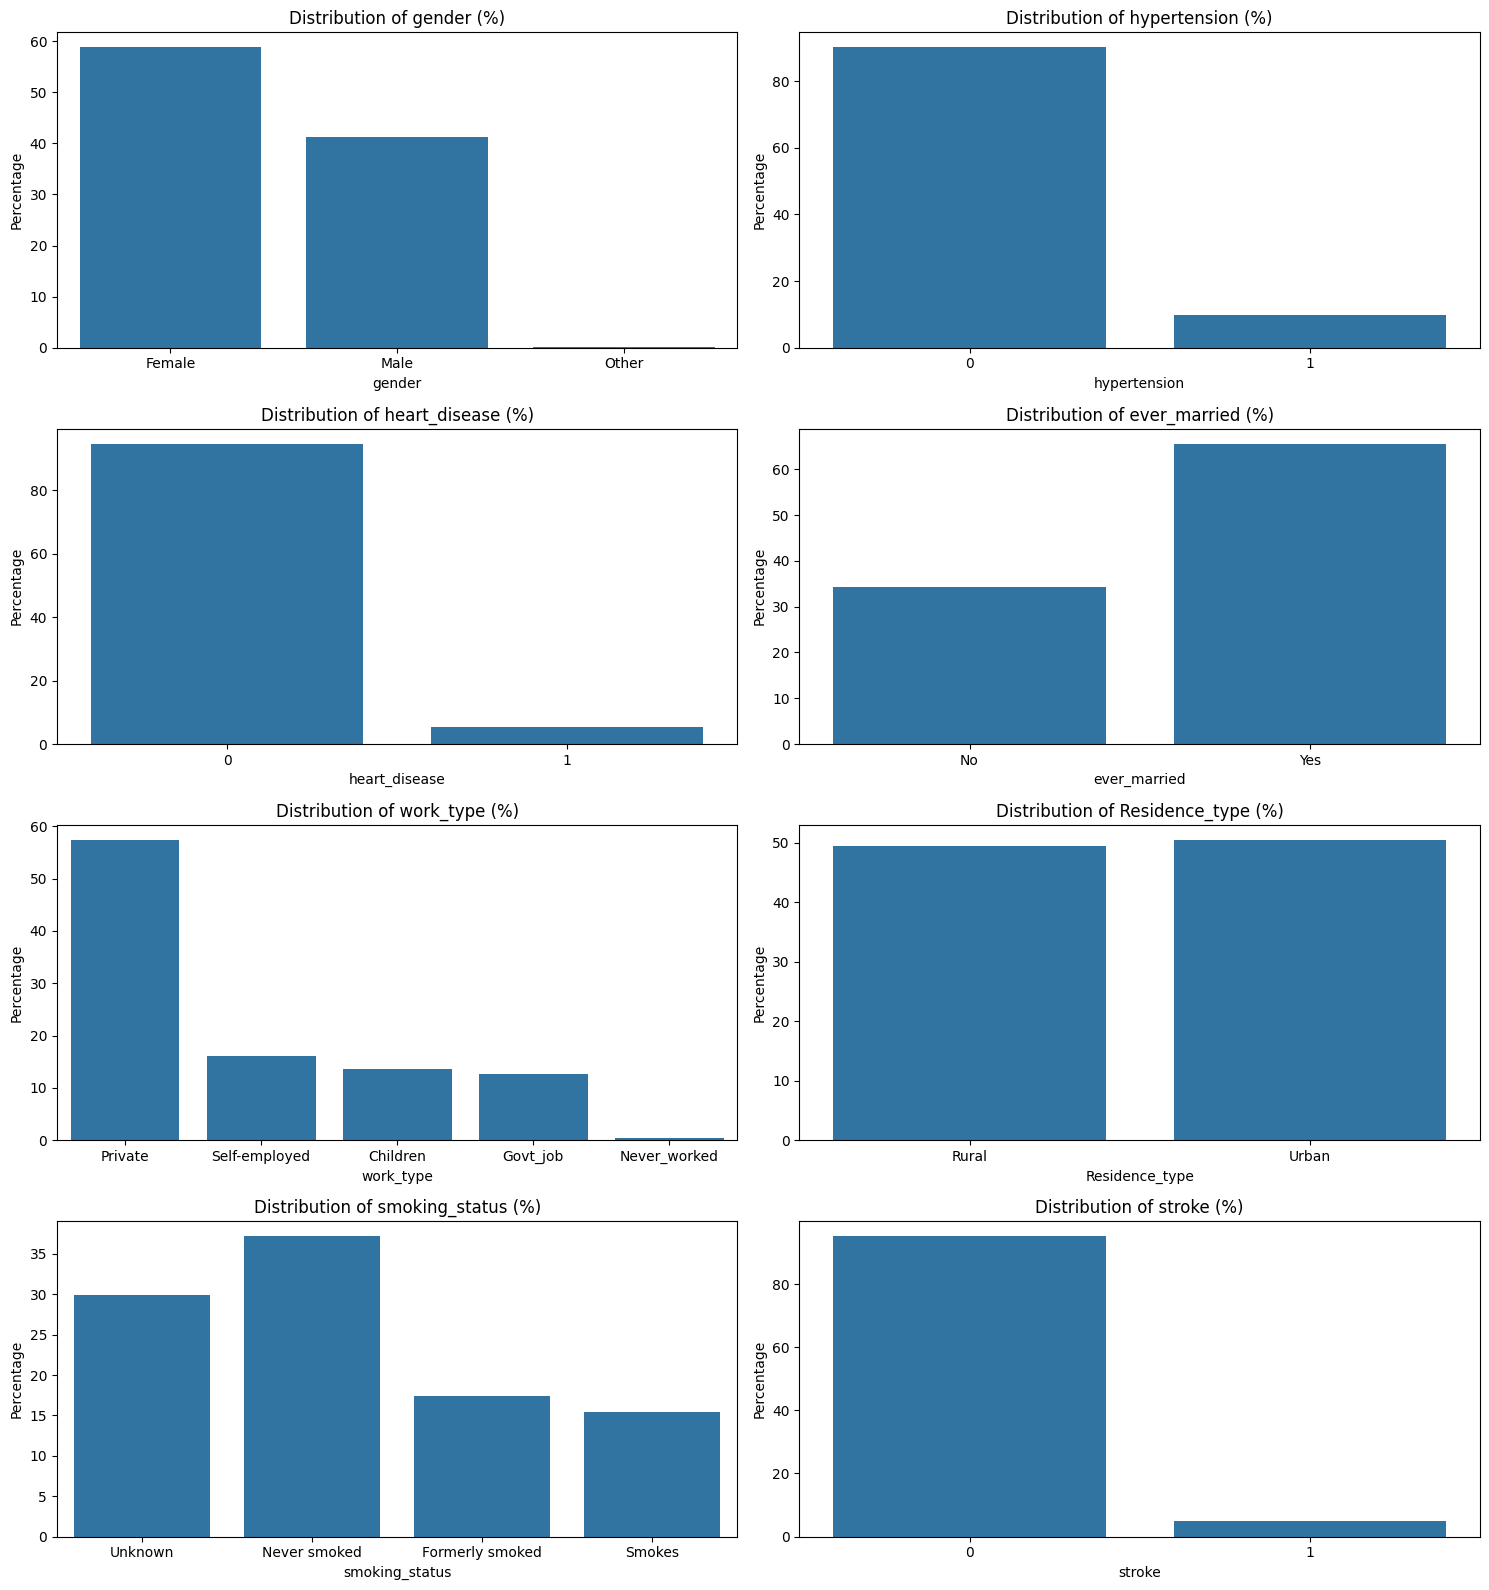

In [16]:
categorical_cols = [col for col in df_cleaned.columns if col not in numerical_cols]
categorical_cols.remove("Unnamed: 0")
categorical_cols.remove("id")

fig, axes = plt.subplots(4,2, figsize = (15,16))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if i < len(axes): 
        sns.countplot(data=df_cleaned, x=col, ax=axes[i], stat = "percent")
        axes[i].set_title(f"Distribution of {col} (%)")
        axes[i].set_ylabel('Percentage')

for j in range(len(categorical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


**Distribution Analysis:**

- Balanced Categories: The distributions in the `smoking_status`, `ever_married` & `Residence_type` columns are well-balanced across their respective categories, indicating a fair representation for each group.

- Severely Imbalanced Categories: The `stroke`, `hypertension` and `heart_disease` columns have a significant amount of imbalance, with the positive class ("1") accounting for less than 10% of the data. This class imbalance might impact model performance and should be addressed during training either through resampling or class weighting. 

- Notable Imbalances in Categories: In the `work_type` category, the "Never_worked" group has very few records compared to other employment types. In `gender`, the "Other" category is significantly lower compared to "Male" and "Female", and may need to be excluded during the modelling process.

## 4. Bivariate Analysis of Features and Target

### Numerical Features and Target

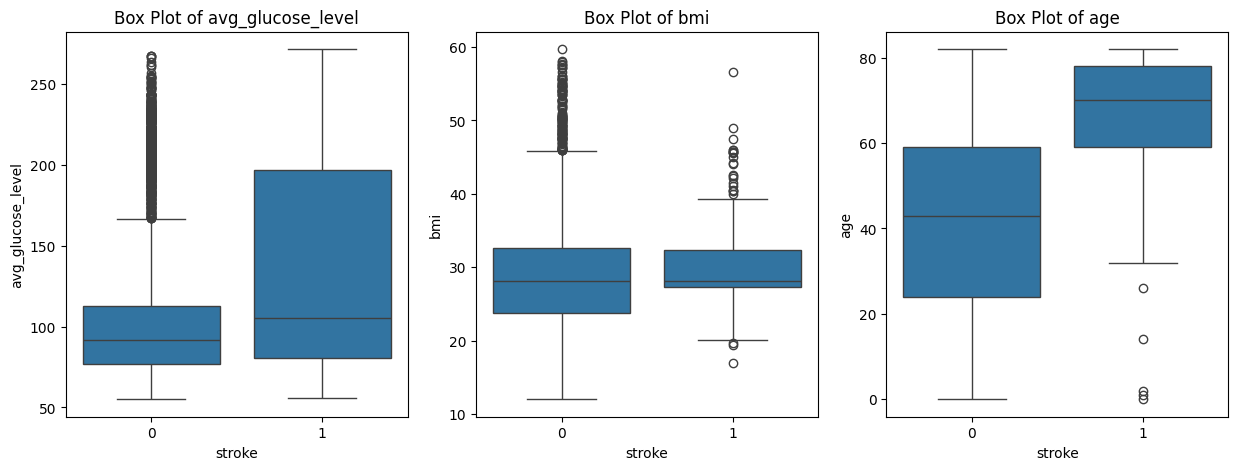

In [17]:
fig, axes = plt.subplots(1,3,figsize = (15,5))

for i, col in enumerate(numerical_cols):
    sns.boxplot(data = df_cleaned, x = "stroke", y= col, ax = axes[i])
    axes[i].set_title(f"Box Plot of {col}")

plt.show()

**Box Plot Analysis:**

`avg_glucose_level`: Patients without stroke have a median blood glucose level of about 90 mg/dl with an IQR of about 30. Stroke patients have a significantly higher median blood glucose level of 110 mg/dl, with an IQR of about 110. Additionally, there are a great number of outlier blood glucose levels in patients without stroke, whereas none are seen in patients with stroke. This indicates that stroke patients have significantly higher blood glucose levels with larger variation, suggesting that pre-diabetes and diabetes might be correlated to stroke risk.

`bmi`: Patients with and without stroke have approximately a median BMI of 28 kg/m2, with very similar distributions and outliers in the high BMI range. This indicates that BMI might have little association with stroke risk.

`age`: The median age for patients without stroke is about 42, with an IQR of approximately 40. In patients with stroke, the median age is substantially higher at about 70 years old with an IQR of 20. Furthermore, the ages of patients without stroke follows a rough normal distribution, whereas those with stroke follow a left-skewed distribution with a few outliers in younger ages. This indicates that the risk of stroke is more constrained towards older patients.

### Categorical Features and Target

In [18]:
categorical_cols.remove("stroke")

for col in categorical_cols:
    crosstab = pd.crosstab(df_cleaned[col], df_cleaned["stroke"], normalize = 'index') * 100
    
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    print(f"Chi-square Association Test for {col}: \n Chi-Square: {chi2:.3f}, p-value: {p_value:.6f} \n")

Chi-square Association Test for gender: 
 Chi-Square: 5.101, p-value: 0.078052 

Chi-square Association Test for hypertension: 
 Chi-Square: 4.867, p-value: 0.027374 

Chi-square Association Test for heart_disease: 
 Chi-Square: 7.004, p-value: 0.008131 

Chi-square Association Test for ever_married: 
 Chi-Square: 1.862, p-value: 0.172338 

Chi-square Association Test for work_type: 
 Chi-Square: 13.771, p-value: 0.008062 

Chi-square Association Test for Residence_type: 
 Chi-Square: 0.000, p-value: 1.000000 

Chi-square Association Test for smoking_status: 
 Chi-Square: 2.304, p-value: 0.511786 



**Statistical Test Analysis:**

Chi-square tests of independence were conducted to examine the association between categorical features and stroke occurence. The significance level was set at 0.05.

The results of the Chi-square test show that occupational factors (`work_type`) and preexisting medical conditions (`hypertension` and `heart_disease`) are primary categorical predictors for stroke risk as their p-values are below the significance level (0.008062, 0.027374, 0.008131 vs 0.05). On the other hand, demographic factors (`gender`, `ever_married`, `Residence_type`) and lifestyle factors (`smoking_status`)  show no direct association to stroke.

## 5. Bivariate Analysis amongst Features

### Numerical Variables

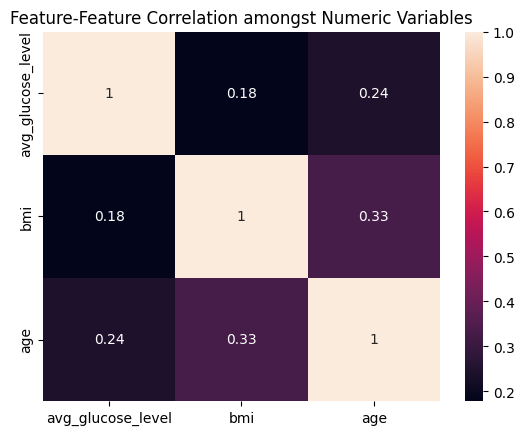

In [19]:
numeric_df = df_cleaned[numerical_cols]

sns.heatmap(numeric_df.corr(), annot = True)
plt.title("Feature-Feature Correlation amongst Numeric Variables")
plt.show()

The heatmap of correlation amongst the numeric variables (`age`, `bmi`, `avg_glucose_level`) has low Pearson coefficient values ranging from 0.18-0.33, indicating that these features are largely independent of each other. This analysis confirms the absence of multicollinearity among numerical preditors, and that there are no redundant features included in the model which might degrade performance and interpretability.

### Categorical Variables

In [20]:
relationship_results = []
feature_pairs = list(combinations(categorical_cols,2))

for feature1, feature2 in feature_pairs:
    chi2_table = pd.crosstab(df_cleaned[feature1], df_cleaned[feature2])
    chi2_stat, p_value, dof, expected = chi2_contingency(chi2_table)

    relationship_results.append({"Feature_1": feature1, "Feature_2": feature2, "p_value": float(round(p_value,4))})

relationship_results = pd.DataFrame(relationship_results)
print(relationship_results.sort_values("p_value"))

         Feature_1       Feature_2  p_value
10    hypertension  smoking_status   0.0000
1           gender   heart_disease   0.0000
3           gender       work_type   0.0000
17    ever_married  smoking_status   0.0000
5           gender  smoking_status   0.0000
6     hypertension   heart_disease   0.0000
7     hypertension    ever_married   0.0000
8     hypertension       work_type   0.0000
15    ever_married       work_type   0.0000
19       work_type  smoking_status   0.0000
11   heart_disease    ever_married   0.0000
12   heart_disease       work_type   0.0000
14   heart_disease  smoking_status   0.0000
2           gender    ever_married   0.0518
20  Residence_type  smoking_status   0.1022
0           gender    hypertension   0.2889
18       work_type  Residence_type   0.5098
4           gender  Residence_type   0.6177
13   heart_disease  Residence_type   0.6678
16    ever_married  Residence_type   0.6870
9     hypertension  Residence_type   0.8132


A Chi-Square test of independence was conducted between pairs of categorical features, with a significance level set at 0.05.

There seems to be a health-related cluster between the pairings of these variables (`hypertension`, `heart_disease`, `smoking_status`) as their p-values were < 0.0001, indicating that there is severe multicollinearity between these features.

There is also a cluster between demographics and lifestyle (`gender` & `heart_disease`, `gender` & `work_type`, `gender` & `smoking_status`, `ever_married` & `smoking_status` and `ever_married` & `work_type`) as their p-values were also < 0.0001. This means that gender has an influence on health outcomes, career choices and lifestyle habits. Marital status also connects to lifestyle and career patterns. Although the `gender` and `ever_married` columns have not shown any direct association to stroke risk in feature-target analysis, they seem to have significant associations with multiple features that have been shown to be a key predictor of stroke.

Additionally, the `Residence_type` feature seems to have no association with other features as their p-values were above the significance level, confirming its lack of predictive value identified in the feature-target analysis.